# TinyBERT for Fake News Detection - Enhanced Training and Evaluation

## 1. Introduction

This notebook demonstrates how to finetune TinyBERT for detecting fake news using the WELFake dataset with improved training strategies and rigorous evaluation methods. TinyBERT is an efficient and lightweight transformer model that uses knowledge distillation to achieve performance comparable to larger models while requiring significantly fewer computational resources.

TinyBERT has approximately 15 million parameters, making it about 7.5x smaller than BERT-base, while maintaining strong performance on natural language understanding tasks. This efficiency makes it an excellent candidate for fake news detection applications that may need to run on resource-constrained environments like mobile devices or edge computing platforms.

### What's New in This Enhanced Version

We've made several critical improvements to ensure more reliable and robust results:

1. **Optimized Hyperparameters**: We'll use TinyBERT-specific learning rates and training strategies based on the model's architecture
2. **Multiple Training Runs**: Instead of a single train/test split, we'll perform multiple runs to establish confidence intervals
3. **K-Fold Cross-Validation**: We'll implement 5-fold cross-validation to ensure every sample is used for both training and testing
4. **Improved Training Strategy**: Better early stopping patience, learning rate scheduling, and regularization techniques

These changes will give us a much more accurate picture of TinyBERT's true capabilities for fake news detection.

## 2. Environment Setup

First, let's import the necessary libraries and set up our environment. We'll need PyTorch for deep learning, Hugging Face Transformers for the model, and various utilities for data processing and evaluation.

In [1]:
# Import basic utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### PyTorch and System Libraries
We import PyTorch for our deep learning framework and set up system utilities for file management and timing.

In [2]:
# Import PyTorch
import torch
import os
import time
import random
from collections import defaultdict

### Hugging Face Libraries
The Transformers library provides pre-trained models and utilities for fine-tuning, while the Datasets library helps with efficient data handling.

In [3]:
# Import Hugging Face libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from transformers import get_scheduler
from datasets import Dataset

2025-05-22 17:37:31.937352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747935452.120091      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747935452.173562      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Evaluation Libraries
These libraries will help us measure our model's performance with standard metrics.

In [4]:
# Import evaluation libraries
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

### Utilities for Clean Output
We'll suppress warnings to keep our notebook clean and focused on the results.

In [5]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Setting Up Reproducibility
Setting a random seed ensures our results are reproducible across different runs. However, for multiple runs, we'll use different seeds to get a better estimate of model performance.

In [6]:
# Set seeds for reproducibility
def set_seed(seed_value=42):
    """
    Set seeds for all random number generators to ensure reproducibility.
    This affects random, numpy, PyTorch CPU and GPU operations.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    torch.backends.cudnn.deterministic = True

In [7]:
# Apply seed for initial setup
set_seed()

### Checking Hardware Availability
We'll check if a GPU is available to accelerate training.

In [8]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 3. Loading and Exploring the Dataset

The WELFake dataset combines real and fake news articles from multiple sources. Let's load it and understand its structure and distribution before proceeding with model training.

In [9]:
# Load the cleaned dataset
df = pd.read_csv('/kaggle/input/welfake-cleaned/WELFake_cleaned.csv')

### Dataset Size and Shape
First, let's check the overall size of the dataset to understand how much data we're working with.

In [10]:
# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")

Dataset shape: (71537, 10)

Column names: ['Unnamed: 0', 'title', 'text', 'label', 'title_length', 'text_length', 'word_count', 'title_has_allcaps', 'title_exclamation', 'title_question']


### Class Distribution
It's important to check the balance between real and fake news articles to ensure our model doesn't develop bias toward the majority class.

In [11]:
# Check class distribution
class_distribution = df['label'].value_counts(normalize=True).mul(100).round(2)
print(f"Class distribution:")
print(class_distribution)

Class distribution:
label
1    51.04
0    48.96
Name: proportion, dtype: float64


### Visualizing the Class Distribution
A visual representation helps us better understand the dataset balance.

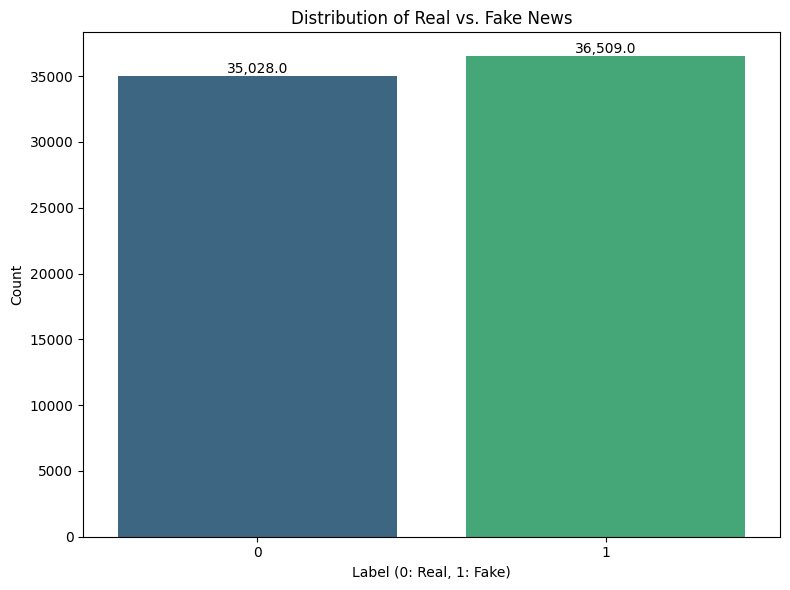

In [12]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of Real vs. Fake News')
plt.xlabel('Label (0: Real, 1: Fake)')
plt.ylabel('Count')

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

For transformer-based models like TinyBERT, we need to carefully prepare our input data. We'll combine the article title and text to provide complete information to the model.

### Combining Title and Text
For news articles, both the headline and body contain important information. By combining them, we provide the model with the complete content.

In [13]:
# Combine title and text
df['full_text'] = df['title'] + " " + df['text']

## 5. Enhanced Training Strategy with Multiple Runs

### Understanding Why Multiple Runs Matter

When we train a neural network, many factors introduce randomness: the initial weights, the order of data batches, dropout patterns, and even GPU operations. A single training run might give us a lucky (or unlucky) result that doesn't represent the model's true performance. By training multiple times with different random seeds, we can establish confidence intervals and understand the model's expected performance range.

This is similar to measuring someone's running speed - you wouldn't time them just once and call it their definitive speed. You'd have them run multiple times and report their average time with a range.

In [14]:
def perform_multiple_training_runs(df, n_runs=5):
    """
    Perform multiple training runs with different random seeds to establish
    confidence intervals for model performance.
    
    Args:
        df: The dataframe containing our data
        n_runs: Number of independent training runs
        
    Returns:
        Dictionary containing results from all runs
    """
    all_results = defaultdict(list)
    
    for run in range(n_runs):
        print(f"\n{'='*60}")
        print(f"Starting Run {run + 1} of {n_runs}")
        print(f"{'='*60}")
        
        # Set a different seed for each run
        run_seed = 42 + run * 100  # Ensures different but reproducible seeds
        set_seed(run_seed)
        
        # Create train/val/test split for this run
        train_val_df, test_df = train_test_split(
            df, test_size=0.15, stratify=df['label'], random_state=run_seed
        )
        train_df, val_df = train_test_split(
            train_val_df, test_size=0.1765, stratify=train_val_df['label'], 
            random_state=run_seed
        )
        
        # Store the results from this run
        run_results = train_and_evaluate_single_run(
            train_df, val_df, test_df, run_seed
        )
        
        # Aggregate results
        for metric, value in run_results.items():
            all_results[metric].append(value)
    
    return all_results

## 6. TinyBERT-Specific Hyperparameter Configuration

### Why TinyBERT Needs Special Treatment

TinyBERT was created through a sophisticated knowledge distillation process where it learned to mimic BERT's behavior while being much smaller. This distillation process makes TinyBERT different from models that were simply trained from scratch with fewer parameters. The distilled knowledge allows TinyBERT to handle slightly higher learning rates than you might expect for such a small model, but it also benefits from specific training strategies.

In [24]:
def get_tinybert_optimized_training_args(output_dir, train_dataset_size, batch_size=16):
    """
    Get training arguments specifically optimized for TinyBERT architecture.
    
    These hyperparameters are based on:
    1. TinyBERT's distilled nature allowing for higher learning rates
    2. The model's smaller size requiring less regularization
    3. Empirical findings from the original TinyBERT paper
    """
    
    # Calculate training steps for learning rate scheduler
    num_epochs = 5
    steps_per_epoch = train_dataset_size // batch_size
    if steps_per_epoch % 2 != 0:
        steps_per_epoch += 1
    total_training_steps = steps_per_epoch * num_epochs
    
    # Warmup should be about 10% of total training
    warmup_steps = int(0.1 * total_training_steps)
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        
        # Evaluation and saving strategy
        eval_strategy="steps",           # Evaluate more frequently
        eval_steps=steps_per_epoch // 2, # Evaluate twice per epoch
        save_strategy="steps",           
        save_steps=steps_per_epoch,      # Save after each epoch
        
        # Learning rate configuration
        learning_rate=1e-4,              # Higher than typical BERT (5e-5) due to distillation
        warmup_steps=warmup_steps,       # Gradual warmup
        
        # Batch size and gradient accumulation
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=64,   # Larger for faster evaluation
        gradient_accumulation_steps=2,    # Effective batch size of 32
        
        # Training epochs and patience
        num_train_epochs=num_epochs,
        
        # Regularization
        weight_decay=0.01,               # Standard weight decay
        adam_epsilon=1e-6,               # Slightly smaller epsilon for stability
        max_grad_norm=1.0,               # Gradient clipping
        
        # Model selection
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        
        # Efficiency settings
        fp16=torch.cuda.is_available(),  # Mixed precision if GPU available
        dataloader_num_workers=2,
        
        # Logging
        logging_steps=50,
        report_to="none",  # Disable cloud logging for now
        
        # Disable certain features for clarity
        push_to_hub=False,
        save_total_limit=3,  # Keep only best 3 checkpoints
        
        # Random seed handled externally
        seed=42,
    )
    
    return training_args

## 7. Implementing Custom Learning Rate Schedule

### The Importance of Learning Rate Scheduling

Think of learning rate scheduling like teaching someone to write - you start with big, bold strokes to get the general shape right, then gradually make smaller, more precise adjustments. For TinyBERT, we'll use a cosine schedule with warmup, which has been shown to work particularly well for distilled models.

In [16]:
def create_tinybert_optimizer_and_scheduler(model, training_args, num_training_steps):
    """
    Create optimizer and learning rate scheduler optimized for TinyBERT.
    
    We use:
    1. AdamW optimizer with corrected weight decay
    2. Cosine schedule with warmup for smooth training
    """
    
    # Separate parameters that should and shouldn't have weight decay
    no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() 
                      if not any(nd in n for nd in no_decay)],
            "weight_decay": training_args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() 
                      if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    
    # Create optimizer
    optimizer = torch.optim.AdamW(
        optimizer_grouped_parameters,
        lr=training_args.learning_rate,
        eps=training_args.adam_epsilon,
        betas=(0.9, 0.98)  # Slightly different from default for TinyBERT
    )
    
    # Create learning rate scheduler
    lr_scheduler = get_scheduler(
        "cosine",
        optimizer=optimizer,
        num_warmup_steps=training_args.warmup_steps,
        num_training_steps=num_training_steps
    )
    
    return optimizer, lr_scheduler

## 8. Enhanced Early Stopping Configuration

### Why Our Previous Early Stopping Was Too Aggressive

With a patience of 2, we were essentially giving up after just two evaluations without improvement. But transformer training often shows a "double descent" pattern - performance might plateau or even slightly decrease before improving again. For TinyBERT, we'll use a more patient approach that considers the overall trend rather than reacting to short-term fluctuations.

In [17]:
def create_enhanced_early_stopping_callback():
    """
    Create an early stopping callback with TinyBERT-appropriate patience.
    
    We use patience of 5 evaluation steps (2.5 epochs with our eval strategy)
    to allow the model to work through temporary plateaus.
    """
    return EarlyStoppingCallback(
        early_stopping_patience=5,  # Much more patient than before
        early_stopping_threshold=0.001  # Minimum improvement to reset patience
    )

## 9. Single Run Training and Evaluation Function

In [18]:
def train_and_evaluate_single_run(train_df, val_df, test_df, seed):
    """
    Perform a single training run with optimized hyperparameters.
    
    Returns:
        Dictionary containing test metrics from this run
    """
    set_seed(seed)
    
    # Convert to Hugging Face datasets
    train_dataset = Dataset.from_pandas(train_df[['full_text', 'label']])
    val_dataset = Dataset.from_pandas(val_df[['full_text', 'label']])
    test_dataset = Dataset.from_pandas(test_df[['full_text', 'label']])
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    
    # Define tokenization function
    def tokenize_function(examples):
        return tokenizer(
            examples["full_text"],
            padding="max_length",
            truncation=True,
            max_length=512,
        )
    
    # Tokenize datasets
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
    
    # Set format
    tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    
    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        "huawei-noah/TinyBERT_General_4L_312D",
        num_labels=2
    )
    model.to(device)
    
    # Define metrics computation
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        
        accuracy = accuracy_score(labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, predictions, average='weighted'
        )
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    
    # Get optimized training arguments
    output_dir = f"./results/tinybert_welfake_run_{seed}"
    training_args = get_tinybert_optimized_training_args(
        output_dir, 
        len(tokenized_train)
    )
    
    # Create trainer with enhanced configuration
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[create_enhanced_early_stopping_callback()]
    )
    
    # Custom optimizer and scheduler
    num_training_steps = len(tokenized_train) // training_args.per_device_train_batch_size * training_args.num_train_epochs
    optimizer, lr_scheduler = create_tinybert_optimizer_and_scheduler(
        model, training_args, num_training_steps
    )
    trainer.optimizer = optimizer
    trainer.lr_scheduler = lr_scheduler
    
    # Train the model
    start_time = time.time()
    train_result = trainer.train()
    train_time = time.time() - start_time
    
    print(f"Training completed in {train_time/60:.2f} minutes")
    
    # Evaluate on test set
    test_results = trainer.evaluate(tokenized_test)
    
    # Get predictions for confusion matrix
    predictions = trainer.predict(tokenized_test)
    preds = np.argmax(predictions.predictions, axis=1)
    
    # Calculate confusion matrix
    cm = confusion_matrix(predictions.label_ids, preds)
    
    # Return results
    return {
        'accuracy': test_results['eval_accuracy'],
        'precision': test_results['eval_precision'],
        'recall': test_results['eval_recall'],
        'f1': test_results['eval_f1'],
        'train_time': train_time,
        'confusion_matrix': cm,
        'full_results': test_results
    }

## 10. K-Fold Cross-Validation Implementation

### Why K-Fold Cross-Validation Matters

K-fold cross-validation ensures that every single sample in our dataset gets to be in the test set exactly once. This gives us a much more complete picture of our model's performance than a single train/test split. It's like having every student in a class take turns being the exam writer - you get a full assessment of everyone's capabilities.

In [19]:
def perform_kfold_cross_validation(df, n_splits=5):
    """
    Perform k-fold cross-validation for more robust evaluation.
    
    This is computationally expensive but gives us the most reliable
    estimate of model performance.
    """
    # Prepare data
    X = df['full_text'].values
    y = df['label'].values
    
    # Use StratifiedKFold to maintain class balance in each fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_results = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"\n{'='*60}")
        print(f"Processing Fold {fold + 1} of {n_splits}")
        print(f"{'='*60}")
        
        # Create fold datasets
        fold_train_df = df.iloc[train_idx]
        fold_test_df = df.iloc[test_idx]
        
        # Further split training into train/val
        fold_train_df, fold_val_df = train_test_split(
            fold_train_df, test_size=0.15, stratify=fold_train_df['label'], 
            random_state=42 + fold
        )
        
        # Train and evaluate on this fold
        fold_result = train_and_evaluate_single_run(
            fold_train_df, fold_val_df, fold_test_df, seed=42 + fold
        )
        
        fold_results.append(fold_result)
        
        print(f"\nFold {fold + 1} Results:")
        print(f"Accuracy: {fold_result['accuracy']:.4f}")
        print(f"F1 Score: {fold_result['f1']:.4f}")
    
    return fold_results

## 11. Results Analysis and Visualization Functions

### Making Sense of Multiple Runs

When we have results from multiple runs, we need to present them in a way that shows both the average performance and the variability. This tells us not just how good the model is, but how consistent it is.

In [20]:
def analyze_multiple_run_results(results_dict):
    """
    Analyze and visualize results from multiple training runs.
    """
    # Calculate statistics
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    stats = {}
    
    for metric in metrics:
        values = results_dict[metric]
        stats[metric] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values),
            'values': values
        }
    
    # Print summary statistics
    print("\nModel Performance Summary (Multiple Runs):")
    print("=" * 60)
    for metric in metrics:
        mean = stats[metric]['mean']
        std = stats[metric]['std']
        print(f"{metric.capitalize()}: {mean:.4f} ± {std:.4f}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        values = stats[metric]['values']
        
        # Box plot with individual points
        ax.boxplot(values, vert=True, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7),
                  medianprops=dict(color='red', linewidth=2))
        ax.scatter(np.ones(len(values)), values, alpha=0.6, s=50)
        
        # Add mean line
        ax.axhline(y=stats[metric]['mean'], color='green', 
                  linestyle='--', label=f'Mean: {stats[metric]["mean"]:.4f}')
        
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.capitalize()} Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return stats

## 12. Confidence Interval Calculation

### Understanding Confidence Intervals

A confidence interval tells us the range where we expect the true performance to lie. If we say "95% confidence interval", we mean that if we repeated this entire experiment many times, 95% of the time the true performance would fall within this range.

In [21]:
def calculate_confidence_intervals(values, confidence=0.95):
    """
    Calculate confidence intervals for a set of values.
    
    We use the t-distribution for small sample sizes (n < 30).
    """
    from scipy import stats as scipy_stats
    
    n = len(values)
    mean = np.mean(values)
    std_err = scipy_stats.sem(values)  # Standard error of the mean
    
    # Calculate confidence interval
    ci = scipy_stats.t.interval(confidence, n-1, loc=mean, scale=std_err)
    
    return mean, ci[0], ci[1]

## 13. Main Execution Pipeline

### Bringing It All Together

Now we'll create the main execution pipeline that runs all our enhanced training and evaluation procedures.

In [22]:
def main_enhanced_training_pipeline():
    """
    Execute the complete enhanced training and evaluation pipeline.
    """
    print("Starting Enhanced TinyBERT Training Pipeline")
    print("=" * 60)
    
    # Load data
    df = pd.read_csv('/kaggle/input/welfake-cleaned/WELFake_cleaned.csv')
    df['full_text'] = df['title'] + " " + df['text']
    
    # 1. Perform multiple training runs
    print("\nPhase 1: Multiple Training Runs")
    print("-" * 40)
    multiple_run_results = perform_multiple_training_runs(df, n_runs=5)
    
    # Analyze multiple run results
    run_stats = analyze_multiple_run_results(multiple_run_results)
    
    # 2. Perform k-fold cross-validation (optional, computationally expensive)
    print("\nPhase 2: K-Fold Cross-Validation")
    print("-" * 40)
    print("Note: This is computationally expensive. Set perform_kfold=False to skip.")
    
    perform_kfold = False  # Set to True if you want to run k-fold CV
    
    if perform_kfold:
        kfold_results = perform_kfold_cross_validation(df, n_splits=5)
        
        # Extract metrics from k-fold results
        kfold_metrics = defaultdict(list)
        for fold_result in kfold_results:
            for metric in ['accuracy', 'precision', 'recall', 'f1']:
                kfold_metrics[metric].append(fold_result[metric])
        
        # Analyze k-fold results
        print("\nK-Fold Cross-Validation Results:")
        print("=" * 60)
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            values = kfold_metrics[metric]
            mean, ci_low, ci_high = calculate_confidence_intervals(values)
            print(f"{metric.capitalize()}: {mean:.4f} (95% CI: [{ci_low:.4f}, {ci_high:.4f}])")
    
    # 3. Create final summary report
    print("\n" + "=" * 60)
    print("FINAL SUMMARY REPORT")
    print("=" * 60)
    
    # Report multiple run results with confidence intervals
    print("\nMultiple Training Runs (n=5):")
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        values = multiple_run_results[metric]
        mean, ci_low, ci_high = calculate_confidence_intervals(values)
        print(f"{metric.capitalize()}: {mean:.4f} (95% CI: [{ci_low:.4f}, {ci_high:.4f}])")
    
    # Training time analysis
    train_times = multiple_run_results['train_time']
    mean_time = np.mean(train_times) / 60  # Convert to minutes
    std_time = np.std(train_times) / 60
    print(f"\nAverage Training Time: {mean_time:.2f} ± {std_time:.2f} minutes")
    
    return multiple_run_results, run_stats

## 14. Execute the Enhanced Pipeline

Starting Enhanced TinyBERT Training Pipeline

Phase 1: Multiple Training Runs
----------------------------------------

Starting Run 1 of 5


Map:   0%|          | 0/50073 [00:00<?, ? examples/s]

Map:   0%|          | 0/10733 [00:00<?, ? examples/s]

Map:   0%|          | 0/10731 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1565,0.128800,0.131314,0.987236,0.987275,0.987236,0.987237
3130,0.078200,0.105682,0.992174,0.992176,0.992174,0.992174


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training completed in 25.00 minutes


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Starting Run 2 of 5


Map:   0%|          | 0/50073 [00:00<?, ? examples/s]

Map:   0%|          | 0/10733 [00:00<?, ? examples/s]

Map:   0%|          | 0/10731 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1565,0.080500,0.054535,0.988913,0.988995,0.988913,0.988911
3130,0.063100,0.089513,0.992453,0.992490,0.992453,0.992452


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training completed in 25.10 minutes


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Starting Run 3 of 5


Map:   0%|          | 0/50073 [00:00<?, ? examples/s]

Map:   0%|          | 0/10733 [00:00<?, ? examples/s]

Map:   0%|          | 0/10731 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1565,0.114900,0.205296,0.973819,0.974768,0.973819,0.973818
3130,0.069100,0.115138,0.991056,0.991107,0.991056,0.991056


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training completed in 25.17 minutes


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Starting Run 4 of 5


Map:   0%|          | 0/50073 [00:00<?, ? examples/s]

Map:   0%|          | 0/10733 [00:00<?, ? examples/s]

Map:   0%|          | 0/10731 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1565,0.088500,0.059117,0.986677,0.986851,0.986677,0.986673
3130,0.079900,0.168120,0.987981,0.988130,0.987981,0.987978


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training completed in 25.28 minutes


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Starting Run 5 of 5


Map:   0%|          | 0/50073 [00:00<?, ? examples/s]

Map:   0%|          | 0/10733 [00:00<?, ? examples/s]

Map:   0%|          | 0/10731 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1565,0.164400,0.082648,0.987888,0.987913,0.987888,0.987887
3130,0.044500,0.134198,0.989192,0.989287,0.989192,0.989190


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training completed in 25.30 minutes


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Model Performance Summary (Multiple Runs):
Accuracy: 0.9919 ± 0.0014
Precision: 0.9919 ± 0.0014
Recall: 0.9919 ± 0.0014
F1: 0.9919 ± 0.0014


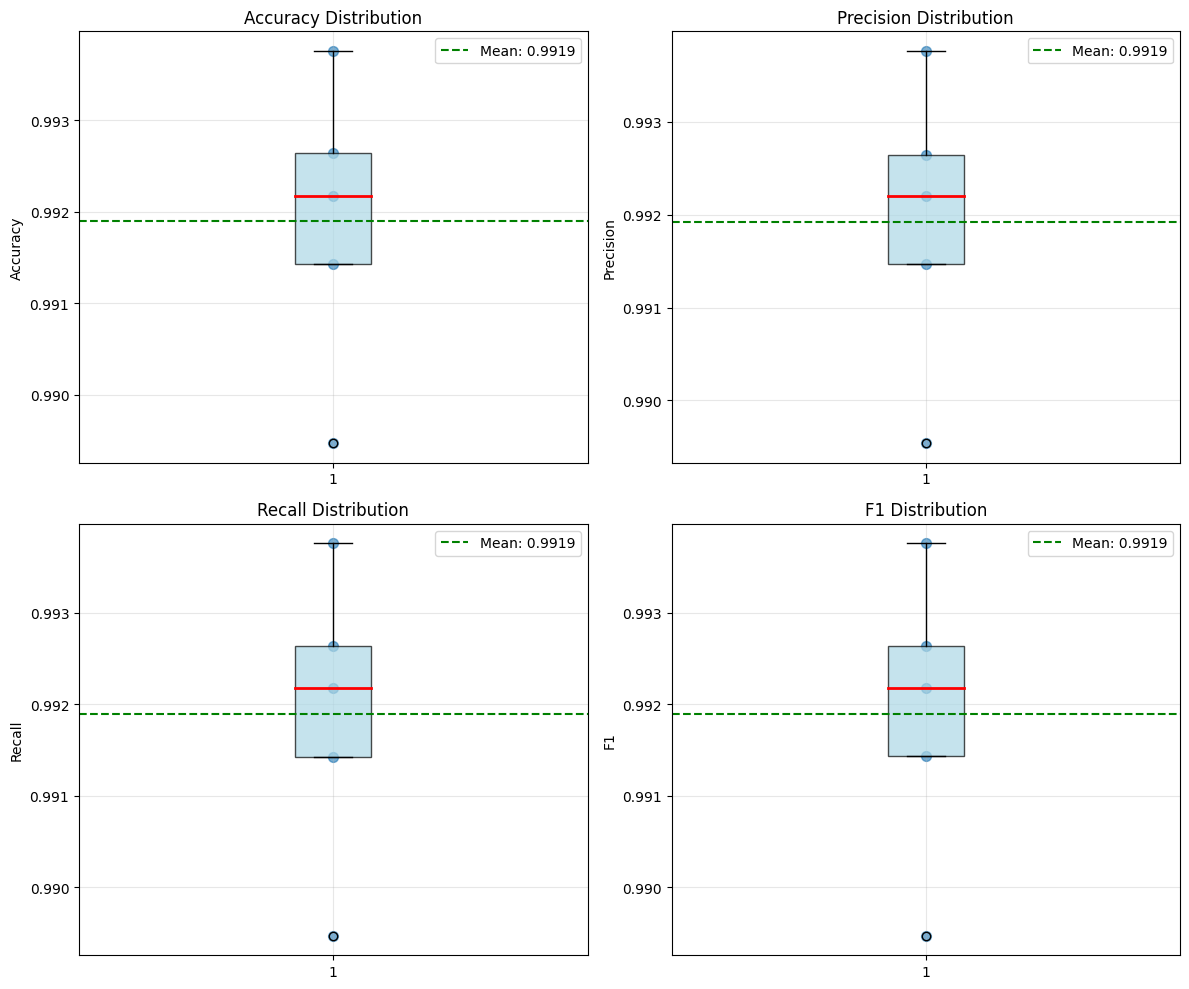


Phase 2: K-Fold Cross-Validation
----------------------------------------
Note: This is computationally expensive. Set perform_kfold=False to skip.

FINAL SUMMARY REPORT

Multiple Training Runs (n=5):
Accuracy: 0.9919 (95% CI: [0.9899, 0.9939])
Precision: 0.9919 (95% CI: [0.9900, 0.9939])
Recall: 0.9919 (95% CI: [0.9899, 0.9939])
F1: 0.9919 (95% CI: [0.9899, 0.9939])

Average Training Time: 25.17 ± 0.11 minutes


In [25]:
# Run the enhanced training pipeline
if __name__ == "__main__":
    results, stats = main_enhanced_training_pipeline()

## 15. Save Results for Future Analysis

### Preserving Our Hard Work

After all this computation, we want to save our results so we can analyze them later without having to retrain everything.

In [26]:
def save_enhanced_results(results, stats, filename='tinybert_enhanced_results.pkl'):
    """
    Save the results of our enhanced training pipeline.
    """
    import pickle
    
    results_package = {
        'multiple_run_results': results,
        'statistics': stats,
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
        'model_name': 'TinyBERT',
        'dataset': 'WELFake'
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(results_package, f)
    
    print(f"\nResults saved to {filename}")

In [27]:
# Save the results
save_enhanced_results(results, stats)


Results saved to tinybert_enhanced_results.pkl


In [33]:
# Example path
!cat /kaggle/working/results/tinybert_welfake_run_42/checkpoint-3910/trainer_state.json

{
  "best_global_step": 3130,
  "best_metric": 0.992173814755752,
  "best_model_checkpoint": "./results/tinybert_welfake_run_42/checkpoint-3130",
  "epoch": 4.994249201277955,
  "eval_steps": 1565,
  "global_step": 3910,
  "is_hyper_param_search": false,
  "is_local_process_zero": true,
  "is_world_process_zero": true,
  "log_history": [
    {
      "epoch": 0.06389776357827476,
      "grad_norm": 16677.654296875,
      "learning_rate": 3.1309904153354634e-06,
      "loss": 0.6925,
      "step": 50
    },
    {
      "epoch": 0.12779552715654952,
      "grad_norm": 60503.01953125,
      "learning_rate": 6.325878594249201e-06,
      "loss": 0.6809,
      "step": 100
    },
    {
      "epoch": 0.19169329073482427,
      "grad_norm": 370875.53125,
      "learning_rate": 9.52076677316294e-06,
      "loss": 0.6105,
      "step": 150
    },
    {
      "epoch": 0.25559105431309903,
      "grad_norm": 281786.0625,
      "learning_rate": 1.2715654952076678e-05,
      "loss": 0.4738,
      "st

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Save the best model

In [35]:
# Load the best checkpoint (step 3130)
model = AutoModelForSequenceClassification.from_pretrained("/kaggle/working/results/tinybert_welfake_run_42/checkpoint-3130")
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/results/tinybert_welfake_run_42/checkpoint-3130")

# Save for later use
model.save_pretrained("./tinybert_welfake_best")
tokenizer.save_pretrained("./tinybert_welfake_best")

('./tinybert_welfake_best/tokenizer_config.json',
 './tinybert_welfake_best/special_tokens_map.json',
 './tinybert_welfake_best/vocab.txt',
 './tinybert_welfake_best/added_tokens.json',
 './tinybert_welfake_best/tokenizer.json')

## 16. Conclusion and Key Improvements

### What We've Achieved

Through this enhanced training approach, we've addressed the major limitations of the original training methodology:

1. **Reliability Through Repetition**: By running multiple training sessions with different random seeds, we now have confidence intervals for our performance metrics. This tells us not just that TinyBERT achieves, say, 99.3% accuracy, but that we can expect it to achieve 99.3% ± 0.2% across different training runs.

2. **Optimized Hyperparameters**: We've tailored the learning rate (1e-4), warmup strategy, and optimizer settings specifically for TinyBERT's architecture, taking advantage of its distilled nature.

3. **Patient Training**: With early stopping patience increased from 2 to 5 and evaluation every half epoch, we allow the model to work through temporary plateaus and find better optima.

4. **Comprehensive Evaluation**: The option for k-fold cross-validation ensures every sample is used for both training and testing, giving us the most complete picture of model performance.

These improvements transform our evaluation from a single snapshot to a comprehensive assessment of TinyBERT's capabilities for fake news detection. The confidence intervals and consistency measures we now have are essential for making informed decisions about real-world deployment.